In [1]:
from NCA.model.NCA_model import NCA
from NCA.trainer.NCA_trainer import *
#from Common.utils import *
from NCA.NCA_visualiser import *
import optax
import numpy as np
import scipy as sp
import jax.numpy as jnp
import jax
import random
import skimage
import sys
from pathlib import Path
from typing import Union
import glob
import pickle
from tqdm import tqdm
from matplotlib.animation import FuncAnimation

2024-03-24 11:26:52.032062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 11:26:52.032087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 11:26:52.032922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 11:26:52.881353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [36]:
def adhesion_mask_convex_hull_triangle(data):
    """
    Given data output from load_sequence_*, returns a binary mask representing the triangle where cells can adhere.

    Parameters
    ----------
    data : float32 array [T,1,size,size,4]
        timesteps (T) of RGBA images. Dummy index of 1 for number of batches

    rscale : float32
        scales how much bigger or smaller the radius of the mask is

    Returns
    -------
    mask : boolean array [1,size,size]
        Array with circle of 1/0 indicating likely presence/lack of adhesive surface in micropattern
    """

    thresh = np.mean(data,axis=-1) 
    thresh = sp.ndimage.gaussian_filter(thresh,1)  

    k = thresh>np.mean(thresh)
    k = skimage.morphology.convex_hull_image(k,tolerance=0.1)
    r0 = k.shape[1]/1.1
    c0 = 0
    r1 = 0
    c1 = k.shape[0]/1.1
    r2 = k.shape[1]/1.1
    c2 = k.shape[0]/1.1
    
    def cost(params):
        r0,r1,r2,c0,c1,c2 = params
        coords = skimage.draw.polygon([r0,r1,r2],[c0,c1,c2], shape=k.shape)
        template = np.zeros_like(k)
        template[coords] = 1
        return -np.sum(template == k)

    r0,r1,r2,c0,c1,c2= sp.optimize.fmin(cost, (r0,r1,r2,c0,c1,c2),disp=False)
    mask = np.zeros(k.shape,dtype="float32")
    
    coords = skimage.draw.polygon([r0,r1,r2],[c0,c1,c2], shape=k.shape)
    
    mask[coords] = 1
    
    return mask,k
    

In [4]:
def load_images(impath):
    filenames = glob.glob(impath)
    filenames = list(sorted(filenames))
    #print(sorted(filenames))
    ims = []
    for f_str in filenames:
        ims.append(skimage.io.imread(f_str))
    #print(jax.tree_util.tree_structure(ims))
    normalise = lambda arr : arr/np.max(arr,axis=(0,1))
    ims = list(map(normalise,ims))
    return ims


In [46]:
imtype = "IWP2"
data_triangle = load_images("../Data/micropattern_shapes/Max Projections */lowres/*Triangle*")
data_ellipse = load_images("../Data/micropattern_shapes/Max Projections */lowres/*Ellipse*")
data_disc = load_images("../Data/micropattern_shapes/Max Projections */lowres/*Disc*")

16


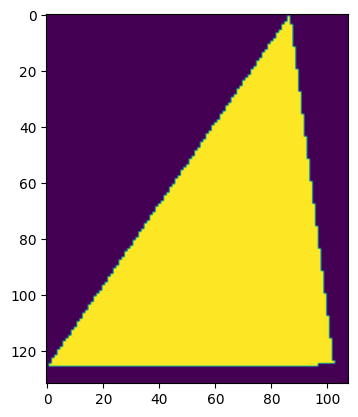

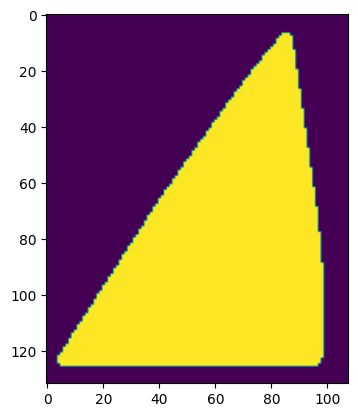

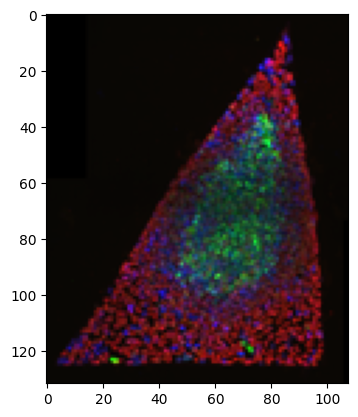

In [47]:
d = data_triangle[0]
print(len(data_triangle))
mask,k = adhesion_mask_convex_hull_triangle(d)
plt.imshow(mask)
plt.show()
plt.imshow(k)
plt.show()
plt.imshow(d[:,:,:3])
plt.show()
